In [7]:
import tensorflow as tf

import os
import math
import pathlib
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


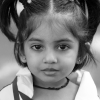

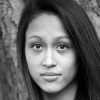

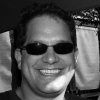

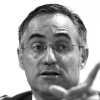

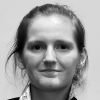

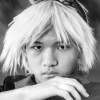

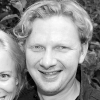

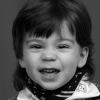

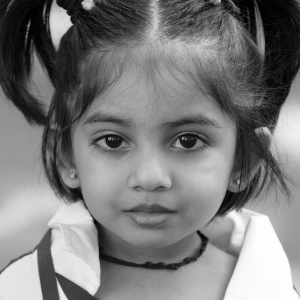

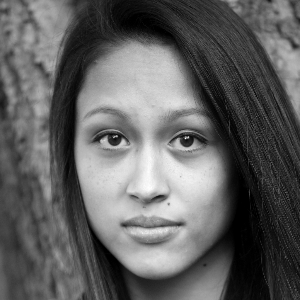

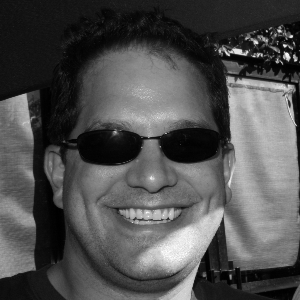

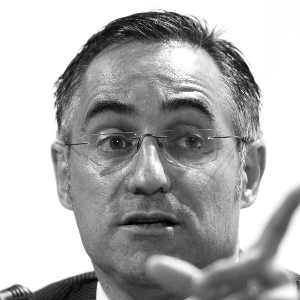

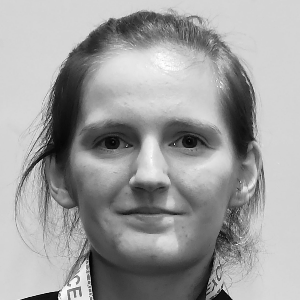

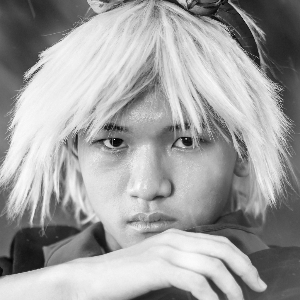

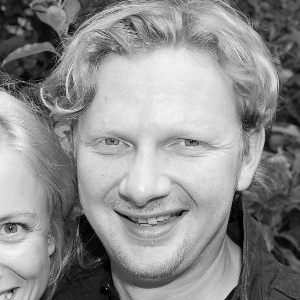

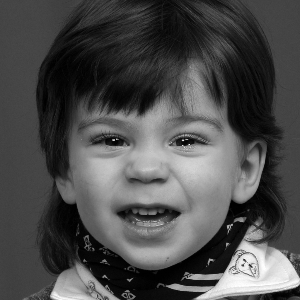

In [18]:
# Caminho das imagens
current_dir = (pathlib.Path(__file__).absolute()).parents[2]
root_dir: str = r"{}/src/images_train".format(current_dir)
    
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

In [19]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [20]:
def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [21]:
test_path = os.path.join(root_dir, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)


class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [22]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 9)     2601      
_________________________________________________________________
tf.nn.depth_to_space_2 (TFOp (None, None, None, 1)     0         
Total params: 59,657
Trainable params: 59,657
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
50/50 - 23s - loss: 0.0406 - val_loss: 0.0043
Mean PSNR for epoch: 24.13


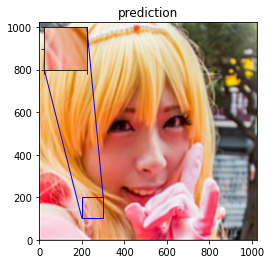

Epoch 2/100
50/50 - 26s - loss: 0.0029 - val_loss: 0.0019
Mean PSNR for epoch: 27.35
Epoch 3/100
50/50 - 26s - loss: 0.0018 - val_loss: 0.0016
Mean PSNR for epoch: 28.10
Epoch 4/100
50/50 - 25s - loss: 0.0016 - val_loss: 0.0015
Mean PSNR for epoch: 28.39
Epoch 5/100
50/50 - 26s - loss: 0.0015 - val_loss: 0.0014
Mean PSNR for epoch: 28.21
Epoch 6/100
50/50 - 27s - loss: 0.0014 - val_loss: 0.0014
Mean PSNR for epoch: 28.42
Epoch 7/100
50/50 - 27s - loss: 0.0014 - val_loss: 0.0014
Mean PSNR for epoch: 28.59
Epoch 8/100
50/50 - 26s - loss: 0.0014 - val_loss: 0.0013
Mean PSNR for epoch: 28.64
Epoch 9/100
50/50 - 25s - loss: 0.0013 - val_loss: 0.0013
Mean PSNR for epoch: 28.68
Epoch 10/100
50/50 - 25s - loss: 0.0015 - val_loss: 0.0015
Mean PSNR for epoch: 28.15
Epoch 11/100
50/50 - 25s - loss: 0.0014 - val_loss: 0.0013
Mean PSNR for epoch: 29.24
Epoch 12/100
50/50 - 25s - loss: 0.0013 - val_loss: 0.0013
Mean PSNR for epoch: 28.91
Epoch 13/100
50/50 - 26s - loss: 0.0013 - val_loss: 0.0013
Mea

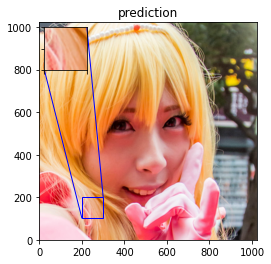

Epoch 22/100
50/50 - 25s - loss: 0.0013 - val_loss: 0.0012
Mean PSNR for epoch: 29.36
Epoch 23/100
50/50 - 27s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 28.88
Epoch 24/100
50/50 - 27s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.19
Epoch 25/100
50/50 - 26s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.04
Epoch 26/100
50/50 - 25s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.31
Epoch 27/100
50/50 - 25s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.06
Epoch 28/100
50/50 - 25s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 28.98
Epoch 29/100
50/50 - 26s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.61
Epoch 30/100
50/50 - 25s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.55
Epoch 31/100
50/50 - 29s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.37
Epoch 32/100
50/50 - 26s - loss: 0.0013 - val_loss: 0.0012
Mean PSNR for epoch: 29.17
Epoch 33/100
50/50 - 26s - loss: 0.0013 - val_loss: 0.

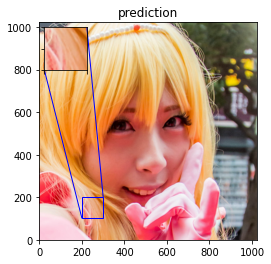

Epoch 42/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 28.97
Epoch 43/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 28.99
Epoch 44/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.38
Epoch 45/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.81
Epoch 46/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.77
Epoch 47/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 28.91
Epoch 48/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.75
Epoch 49/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.07
Epoch 50/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.24
Epoch 51/100
50/50 - 22s - loss: 0.0013 - val_loss: 0.0012
Mean PSNR for epoch: 29.75
Epoch 52/100
50/50 - 23s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.23
Epoch 53/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.

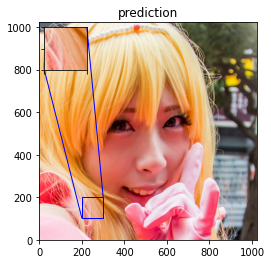

Epoch 62/100
50/50 - 23s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 30.07
Epoch 63/100
50/50 - 23s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.83
Epoch 64/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.24
Epoch 65/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.85
Epoch 66/100
50/50 - 23s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.05
Epoch 67/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0012
Mean PSNR for epoch: 29.17
Epoch 68/100
50/50 - 23s - loss: 0.0016 - val_loss: 0.0012
Mean PSNR for epoch: 29.65
Epoch 69/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.60
Epoch 70/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.77
Epoch 71/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.50
Epoch 72/100
50/50 - 23s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.31
Epoch 73/100
50/50 - 23s - loss: 0.0011 - val_loss: 0.

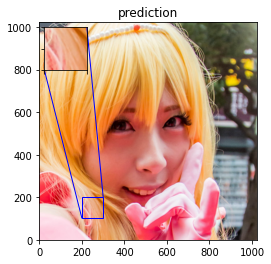

Epoch 82/100
50/50 - 22s - loss: 0.0013 - val_loss: 0.0012
Mean PSNR for epoch: 29.33
Epoch 83/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.17
Epoch 84/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.72
Epoch 85/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.22
Epoch 86/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 30.03
Epoch 87/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.59
Epoch 88/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.66
Epoch 89/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 30.16
Epoch 90/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0011
Mean PSNR for epoch: 29.79
Epoch 91/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.0012
Mean PSNR for epoch: 29.73
Epoch 92/100
50/50 - 22s - loss: 0.0012 - val_loss: 0.0011
Mean PSNR for epoch: 29.01
Epoch 93/100
50/50 - 22s - loss: 0.0011 - val_loss: 0.

In [23]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

PSNR of low resolution image and high resolution image is 38.8371
PSNR of predict and high resolution is 37.9067


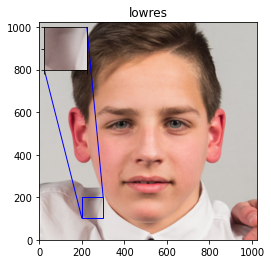

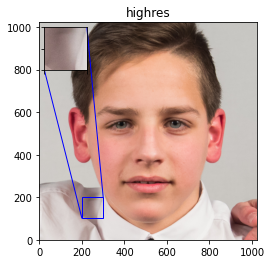

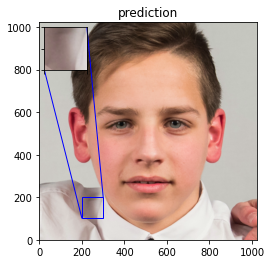

PSNR of low resolution image and high resolution image is 36.6732
PSNR of predict and high resolution is 36.4077


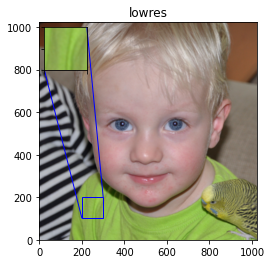

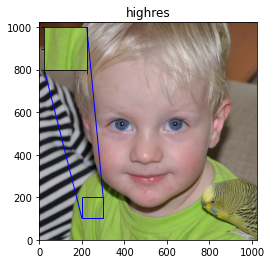

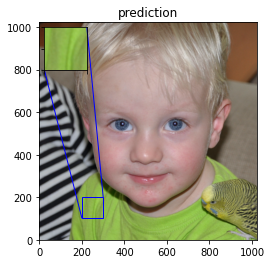

PSNR of low resolution image and high resolution image is 38.8295
PSNR of predict and high resolution is 37.9013


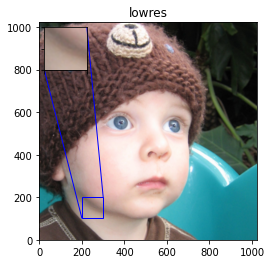

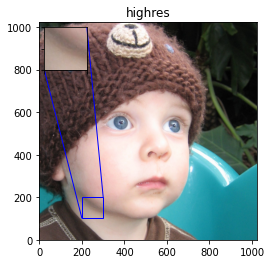

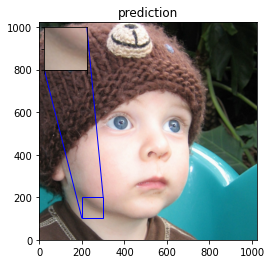

PSNR of low resolution image and high resolution image is 37.4365
PSNR of predict and high resolution is 37.4921


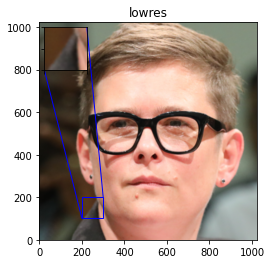

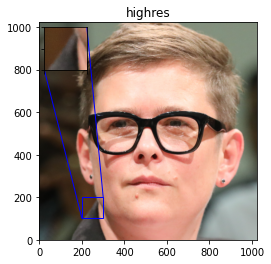

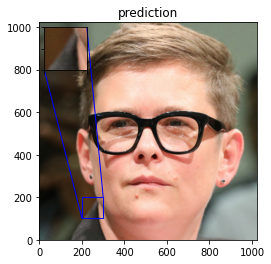

PSNR of low resolution image and high resolution image is 35.4303
PSNR of predict and high resolution is 35.0204


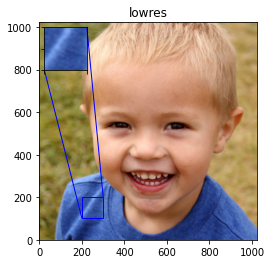

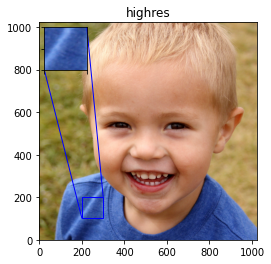

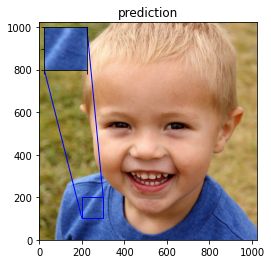

PSNR of low resolution image and high resolution image is 34.4164
PSNR of predict and high resolution is 35.3279


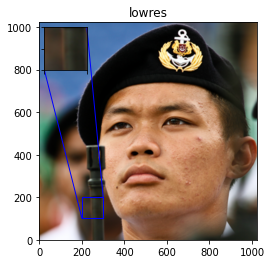

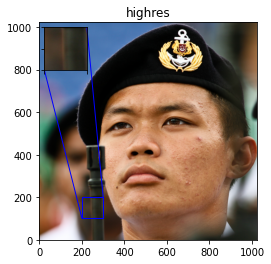

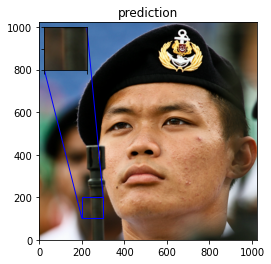

PSNR of low resolution image and high resolution image is 32.4402
PSNR of predict and high resolution is 32.5895


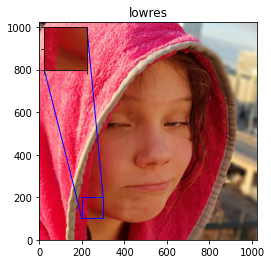

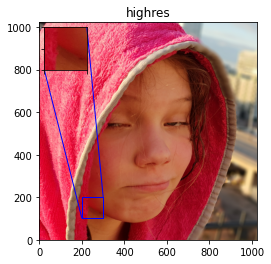

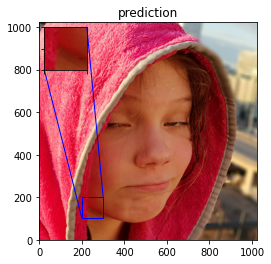

PSNR of low resolution image and high resolution image is 34.8275
PSNR of predict and high resolution is 35.0323


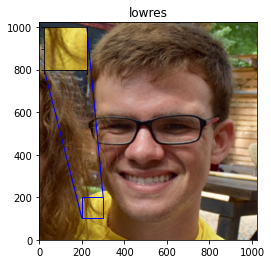

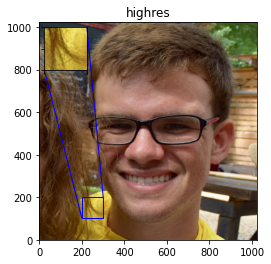

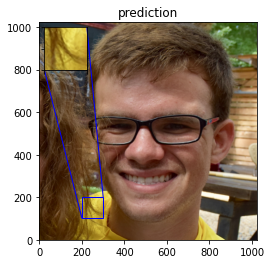

PSNR of low resolution image and high resolution image is 36.7920
PSNR of predict and high resolution is 36.5689


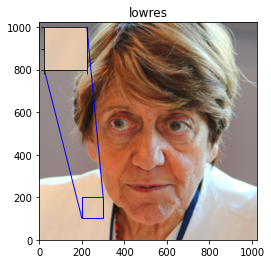

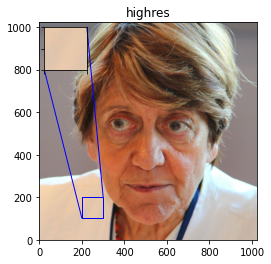

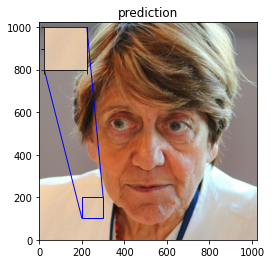

PSNR of low resolution image and high resolution image is 36.7904
PSNR of predict and high resolution is 36.2322


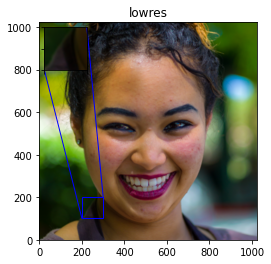

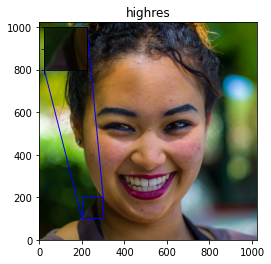

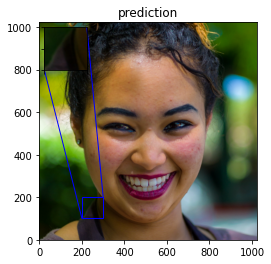

Avg. PSNR of lowres images is 36.2473
Avg. PSNR of reconstructions is 36.0479


In [24]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[10:20]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))